In [70]:
%matplotlib inline
import cv2
from IPython.core.debugger import Tracer
from matplotlib import pyplot as plt
import numpy as np
import time as t
print "OpenCV Version : %s " % cv2.__version__

OpenCV Version : 2.4.12 


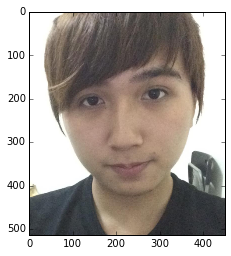

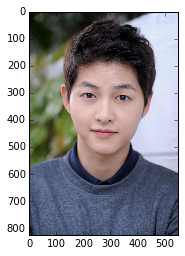

In [71]:
PATH = "yusheng.jpg"
PATH2 = "SongJoongKi.jpg"
img = cv2.imread(PATH)
r = 450.0 / img.shape[1]
dim = (450, int(img.shape[0] * r))
img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)

img2 = cv2.imread(PATH2)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_rgb2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

img_org = img_rgb.copy()
img2_org = img_rgb2.copy()

plt.imshow(img_rgb)
plt.show()
plt.imshow(img_rgb2)
plt.show()


Number of faces detected: 1


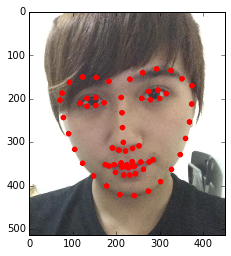

Number of faces detected: 1


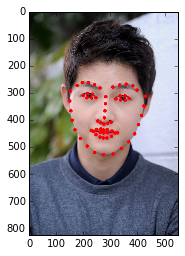

In [72]:
import sys
import os
import dlib
import glob
from skimage import io

def FacialPointDetector( img, img_rgb ) :
    predictor_path = "./shape_predictor_68_face_landmarks.dat"
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor(predictor_path)
    dets = detector(img, 1)
    print("Number of faces detected: {}".format(len(dets)))

    for k, d in enumerate(dets):
    #     print("Detection {}: Left: {} Top: {} Right: {} Bottom: {}".format(
    #         k, d.left(), d.top(), d.right(), d.bottom()))
        # Get the landmarks/parts for the face in box d.
        shape = predictor(img, d)
    #     print("Part 0: {}, Part 1: {} ...".format(shape.part(0),
    #                                               shape.part(1)))
        fp = np.array([[p.x, p.y] for p in predictor(img, d).parts()])
        for i in range(0,68,1):
            cv2.circle( img_rgb, (fp[i][0], fp[i][1]), 6, (255,0,0), cv2.cv.CV_FILLED, cv2.CV_AA, 0 )
    
        return fp
 

fp = FacialPointDetector( img, img_rgb )
plt.imshow(img_rgb)
plt.show()

fp2 = FacialPointDetector( img2, img_rgb2 )
plt.imshow(img_rgb2)
plt.show()

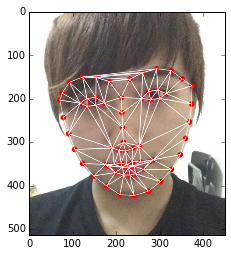

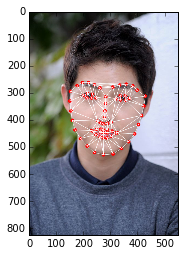

In [73]:
# Check if a point is inside a rectangle
def rect_contains(rect, point) :
    if point[0] < rect[0] :
        return False
    elif point[1] < rect[1] :
        return False
    elif point[0] > rect[2] :
        return False
    elif point[1] > rect[3] :
        return False
    return True

def draw_delaunay(img, subdiv, delaunay_color, fp ) :
 
    triangleList = subdiv.getTriangleList();
    size = img.shape
    r = (0, 0, size[1], size[0])
 
    trList = []
    lmList = [] #follow first triangulation 
    for t in triangleList :
        pt1 = (t[0], t[1])
        pt2 = (t[2], t[3])
        pt3 = (t[4], t[5])
        id1 = 0
        id2 = 0
        id3 = 0
        for i in range(0,68,1):
            if pt1[0]==fp[i][0] and pt1[1]==fp[i][1]:
                id1=i
            if pt2[0]==fp[i][0] and pt2[1]==fp[i][1]:    
                id2=i
            if pt3[0]==fp[i][0] and pt3[1]==fp[i][1]:
                id3=i
                    
        if rect_contains(r, pt1) and rect_contains(r, pt2) and rect_contains(r, pt3) :
            cv2.line(img, pt1, pt2, delaunay_color, 1, cv2.CV_AA, 0)
            cv2.line(img, pt2, pt3, delaunay_color, 1, cv2.CV_AA, 0)
            cv2.line(img, pt3, pt1, delaunay_color, 1, cv2.CV_AA, 0)
            trList.append((pt1, pt2, pt3))
            lmList.append((id1, id2, id3))
                
    print( "Total Trangles: {}".format(len(trList)) )
    return trList, lmList
 
def DrawFacialTriangulation( img, img_rgb, fp, readTheFile ) :
    if readTheFile == False:
        # Rectangle to be used with Subdiv2D
        size = img.shape
        rect = (0, 0, size[1], size[0])

        # Create an instance of Subdiv2D
        subdiv = cv2.Subdiv2D(rect);

        # #test
        # cv2.rectangle(img_rgb, (rect[0],rect[1]), (rect[2],rect[3]), (0, 255, 0), 10)
        # plt.imshow(img_rgb)
        # plt.show()

        # Insert points into subdiv
        for i in range(0,68,1):
            subdiv.insert((fp[i][0], fp[i][1]))

        # Draw delaunay triangles
        lmList = []
        trList, lmList = draw_delaunay( img_rgb, subdiv, (255, 255, 255), fp );
        return trList, lmList
    else:
        # Read triangles from tri.txt
        trList = []
        with open("triIdx.txt") as file :
            for line in file :
                x,y,z = line.split()

                x = int(x)
                y = int(y)
                z = int(z)
                
                pt1 = (fp[x][0], fp[x][1])
                pt2 = (fp[y][0], fp[y][1])
                pt3 = (fp[z][0], fp[z][1])
                
                cv2.line(img_rgb, pt1, pt2, (255, 255, 255), 1, cv2.CV_AA, 0)
                cv2.line(img_rgb, pt2, pt3, (255, 255, 255), 1, cv2.CV_AA, 0)
                cv2.line(img_rgb, pt3, pt1, (255, 255, 255), 1, cv2.CV_AA, 0)
                trList.append((pt1, pt2, pt3))
        
        return trList
    
trList = DrawFacialTriangulation( img, img_rgb, fp, True )
# print(len(lmList))
# triIdx = open("triIdx.txt", "w")
# for i in range(0,len(lmList),1):
#     #print("{} {}".format(i,lmList[i]))
#     if i == len(lmList)-1:
#         triIdx.write("{} {} {}".format(lmList[i][0],lmList[i][1],lmList[i][2]))
#     else:
#         triIdx.write("{} {} {}\n".format(lmList[i][0],lmList[i][1],lmList[i][2]))

# triIdx.close()
plt.imshow(img_rgb)
plt.show()


trList2 = DrawFacialTriangulation( img2, img_rgb2, fp2, True )
plt.imshow(img_rgb2)
plt.show()


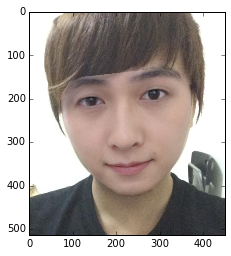

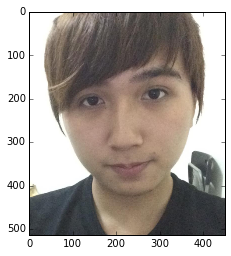

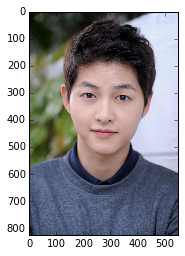

In [74]:
# Apply affine transform calculated using srcTri and dstTri to src and
# output an image of size.
def applyAffineTransform(src, srcTri, dstTri, size) :
    
    # Given a pair of triangles, find the affine transform.
    warpMat = cv2.getAffineTransform( np.float32(srcTri), np.float32(dstTri) )
    
    # Apply the Affine Transform just found to the src image
    dst = cv2.warpAffine( src, warpMat, (size[0], size[1]), None, flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT_101 )

    return dst


def FaceMorphing( img, img2, fp, fp2, trList, trList2, alpha ):
    # Generated Facial Points 
    points = []
    
#     # Compute weighted average point coordinates
#     for i in range(0,68,1):
#         x = int(( 1 - alpha ) * fp[i][0] + alpha * fp2[i][0])
#         y = int(( 1 - alpha ) * fp[i][1] + alpha * fp2[i][1])
#         points.append((x,y))
     
#     # Allocate space for final output
#     imgMorph = np.zeros(img.shape, dtype = img.dtype)
    
#     trListM = []
#     with open("triIdx.txt") as file :
#         for line in file :
#             x,y,z = line.split()

#             x = int(x)
#             y = int(y)
#             z = int(z)

#             pt1 = (points[x][0], points[x][1])
#             pt2 = (points[y][0], points[y][1])
#             pt3 = (points[z][0], points[z][1]) 
#             trListM.append((pt1, pt2, pt3))
    
    imgMorph = img.copy()
    
    for i in range(0,len(trList),1) :
        # Get coordinates of a triangle
        t1 = [trList[i][0],trList[i][1],trList[i][2]]
        t2 = [trList2[i][0],trList2[i][1],trList2[i][2]]
        # t = [trListM[i][0],trListM[i][1],trListM[i][2]]
        t = [trList[i][0],trList[i][1],trList[i][2]]
        
        # Find bounding rectangle for each triangle
        r1 = cv2.boundingRect(np.float32([t1]))
        r2 = cv2.boundingRect(np.float32([t2]))
        r = cv2.boundingRect(np.float32([t]))

        # Offset points by left top corner of the respective rectangles
        t1Rect = []
        t2Rect = []
        tRect = []


        for i in xrange(0, 3):
            tRect.append(((t[i][0] - r[0]),(t[i][1] - r[1])))
            t1Rect.append(((t1[i][0] - r1[0]),(t1[i][1] - r1[1])))
            t2Rect.append(((t2[i][0] - r2[0]),(t2[i][1] - r2[1])))


        # Get mask by filling triangle
        mask = np.zeros((r[3], r[2], 3), dtype = np.float32)
        cv2.fillConvexPoly(mask, np.int32(tRect), (1.0, 1.0, 1.0), 16, 0);

        # Apply warpImage to small rectangular patches
        img1Rect = img[r1[1]:r1[1] + r1[3], r1[0]:r1[0] + r1[2]]
        img2Rect = img2[r2[1]:r2[1] + r2[3], r2[0]:r2[0] + r2[2]]

        size = (r[2], r[3])
        warpImage1 = applyAffineTransform(img1Rect, t1Rect, tRect, size)
        warpImage2 = applyAffineTransform(img2Rect, t2Rect, tRect, size)

        # Alpha blend rectangular patches
        imgRect = (1.0 - alpha) * warpImage1 + alpha * warpImage2

        # Copy triangular region of the rectangular patch to the output image
        imgMorph[r[1]:r[1]+r[3], r[0]:r[0]+r[2]] = imgMorph[r[1]:r[1]+r[3], r[0]:r[0]+
                                                            r[2]] * ( 1 - mask ) + imgRect * mask
    return imgMorph
            
        
alpha = 0.5
imgMorph = FaceMorphing( img_org, img2_org, fp, fp2, trList, trList2, alpha )  
plt.imshow(imgMorph)
plt.show() 

plt.imshow(img_org)
plt.show()

plt.imshow(img2_org)
plt.show()
